<h1 style='text-align:center'> Point Clouds Preprocess </h1>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats


First, we load the sequence and arrange it into an image.


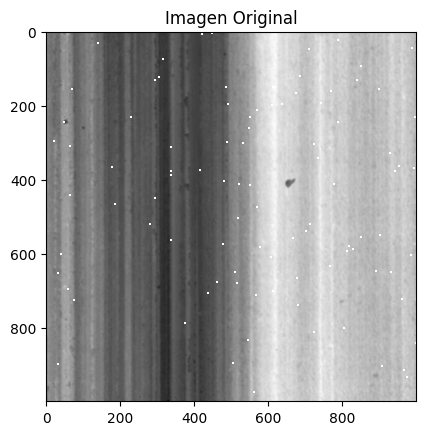

In [3]:
img = np.genfromtxt('./data/tungstenCarbide_NX2_obj20x_zoom1x_215.xyz', skip_header=14, delimiter=" ", comments="D",
                    skip_footer=1)

width = np.max(img[:, 0])
heigth = np.max(img[:, 1])

img_2d = np.zeros((int(heigth) + 1, int(width) + 1))
nan_values = []
for i, z_value in enumerate(img[:, 2]):

    x = int(img[i, 0])
    y = int(img[i, 1])

    if np.isnan(z_value):
        nan_values.append((y, x))

    img_2d[y, x] = z_value

plt.imshow(img_2d, cmap='gray_r')
plt.title('Imagen Original')
plt.show()

There are missing values, we look for them and correct their value to the average of their neighbors.

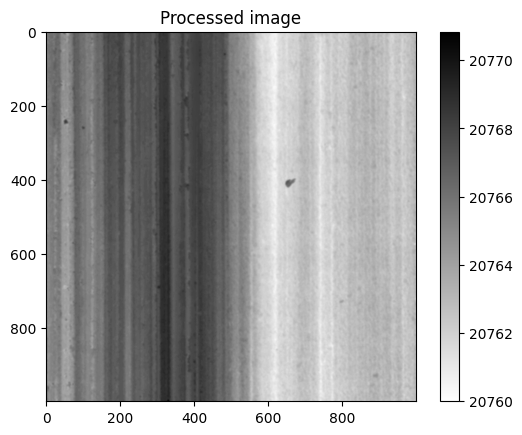

In [4]:
def arreglar_imagen(img):
    """
    :param img: A list of the coordinates of the point cloud
    :return: img_processed: An array with the image sorted and processed
    """
    width = np.max(img[:, 0])
    heigth = np.max(img[:, 1])

    img_2d = np.zeros((int(heigth) + 1, int(width) + 1))
    nan_values = []
    for i, z_value in enumerate(img[:, 2]):

        x = int(img[i, 0])
        y = int(img[i, 1])

        if np.isnan(z_value):
            nan_values.append((y, x))

        img_2d[y, x] = z_value

    alto, ancho = img_2d.shape
    img_processed = img_2d.copy()

    # Recorrer la imagen
    for (y, x) in nan_values:
        # Sumar todos los vecinos y contarlos
        suma = 0
        contador = 0
        for i in [-1, 0, 1]:
            for j in [-1, 0, 1]:
                if 0 <= y + i < alto and 0 <= x + j < ancho and not (np.isnan(img_2d[y + i, x + j])):
                    suma += img_2d[y + i, x + j]
                    contador += 1

        if contador > 0:
            img_processed[y, x] = suma // contador

    tries = 0
    while np.any(np.isnan(img_processed)) and tries < 4:
        img_processed = corregir_nan_con_vecinos(img_processed)
        tries += 1

    return img_processed

def corregir_nan_con_vecinos(imagen):
    # Crear una copia de la imagen para no modificar la original
    imagen_corregida = np.copy(imagen)

    # Obtener las dimensiones de la imagen
    alto, ancho = imagen.shape

    # Iterar sobre cada elemento de la imagen
    for i in range(alto):
        for j in range(ancho):
            # Si el elemento es NaN, calcular la media de sus vecinos
            if np.isnan(imagen[i, j]):
                # Inicializar suma y contador de vecinos válidos
                suma, contador = 0, 0

                # Iterar sobre los vecinos
                for di in range(-1, 2):
                    for dj in range(-1, 2):
                        ni, nj = i + di, j + dj
                        # Verificar si el vecino está dentro de los límites de la imagen
                        if 0 <= ni < alto and 0 <= nj < ancho and not np.isnan(imagen[ni, nj]):
                            suma += imagen[ni, nj]
                            contador += 1

                # Asignar la media de los vecinos al elemento NaN
                if contador > 0:
                    imagen_corregida[i, j] = suma / contador

img_processed = arreglar_imagen(img)

plt.imshow(img_processed, cmap='gray_r')
plt.colorbar()
plt.title('Processed image')
plt.show()

Once we have the processed image, we have to correct the tilt that the piece may have when measuring it because this will affect the Sa or average height of the piece.

To carry out this correction, we first draw two lines on the reference surface, one horizontal and one vertical. We do a linear regression and correct the height by it distance to the lines.

These two lines must be drawn from the reference surface, which is the first 30% of the image. The correction extends to the rest of the image.

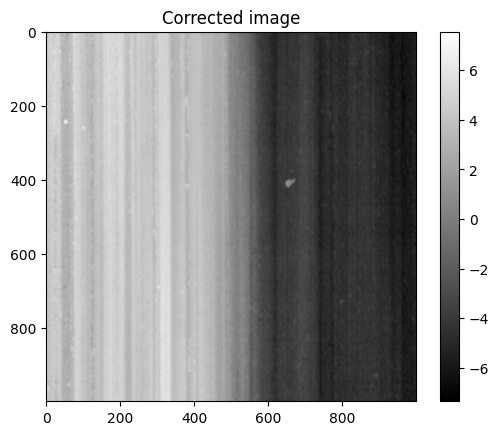

In [5]:
def tilt_correction_slices(img):
    reference_surface = img[:, :int(0.35 * img.shape[1])]
    processed_surface = img[:, int(0.65 * img.shape[1]):]
    vertical_slice = reference_surface[:, int(0.175 * reference_surface.shape[0])]
    horizontal_slice = reference_surface[int(0.5 * reference_surface.shape[1]), :]
    processed_horizontal_slice = processed_surface[int(0.5 * processed_surface.shape[1]), :]

    # El ajuste vertical es facil
    x_vertical = np.arange(0, reference_surface.shape[0])
    pendiente, interseccion, _, _, _ = stats.linregress(x_vertical, vertical_slice)
    y_pred_vertical = pendiente * x_vertical + interseccion

    # El ajuste horizontal: ajustamos pendiente con referencia y la intersecion con la procesada
    x_horizontal = np.arange(0, reference_surface.shape[1])
    pendiente, interseccion, _, _, _ = stats.linregress(x_horizontal, horizontal_slice)
    x_horizontal = np.arange(0, img.shape[1])
    y_pred_horizontal = pendiente * x_horizontal + interseccion

    resultado = img - y_pred_vertical[:, np.newaxis] - y_pred_horizontal[np.newaxis, :]
    resultado = resultado - np.mean(resultado, axis=None)

    return resultado

img_corrected = tilt_correction_slices(img_processed)

# Visualize the distance image.
plt.imshow(img_corrected, cmap='gray')
plt.colorbar()
plt.title('Corrected image')
plt.show()


To get the roughnesses with λ<10 um, we take the spectrum of the image and apply a Gaussian filter.

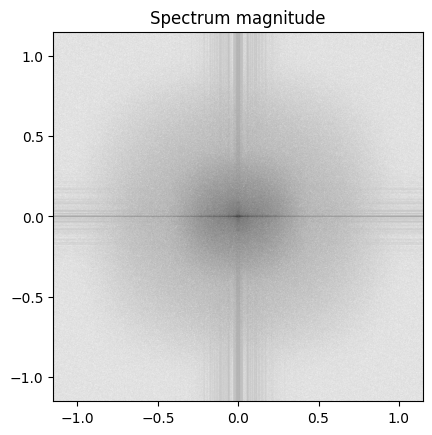

In [6]:
fs = 1/0.434
L = 1000
ejef_x = np.arange(0,500)/L*fs
fft_imagen = np.fft.fft2(img_corrected)
fft_desplazada = np.fft.fftshift(fft_imagen)
magnitud_espectro = np.log(np.abs(fft_desplazada) + 1)

plt.imshow(magnitud_espectro, extent=[-ejef_x[-1], ejef_x[-1], -ejef_x[-1], ejef_x[-1]], cmap='gray_r')
plt.title('Spectrum magnitude')
plt.show()

We must calculate a sigma such that at fc the signal is half. Knowing that FWHM is related to sigma in the following way: FWHM=sqrt(8∗ln(2))​∗sigma, we solve for sigma knowing that FWHM is 0.2 [1/um] in our case.

<img style='text-align:center' src="./data/FWHM.pbm">

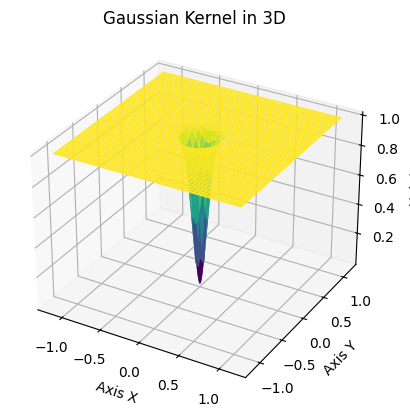

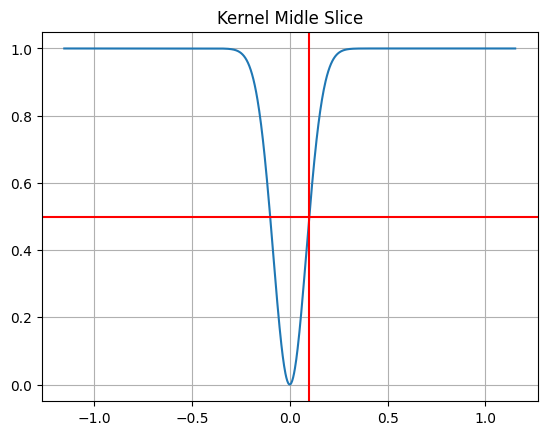

In [7]:
# Gaussian Kernel
# Create the Gaussian kernel
alto, ancho = 1000,1000
x = np.linspace(-ancho//2, ancho//2, ancho)/L*fs
y = np.linspace(-alto//2, alto//2, alto)/L*fs
x, y = np.meshgrid(x, y)
sigma = 0.2/(np.sqrt(8*np.log(2)))
kernel_gaussiano = 1 - np.exp(-(x**2 + y**2) / (2 * sigma**2))

ejef = np.linspace(-500,500,1000)/1000*fs
kenerl1d = kernel_gaussiano[500,:]

# Create the 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
ax.plot_surface(x, y, kernel_gaussiano, cmap='viridis')
ax.set_title('Gaussian Kernel in 3D')
ax.set_xlabel('Axis X')
ax.set_ylabel('Axis Y')
ax.set_zlabel('Height')
plt.show()

plt.plot(ejef, kenerl1d)
plt.title('Kernel Midle Slice')
plt.grid()
plt.axhline(y=0.5, color='r')
plt.axvline(x=0.1, color='r')
plt.show()
plt.show()

We apply the filter to our spectrum and obtain the filtered image by doing the inverse transform.

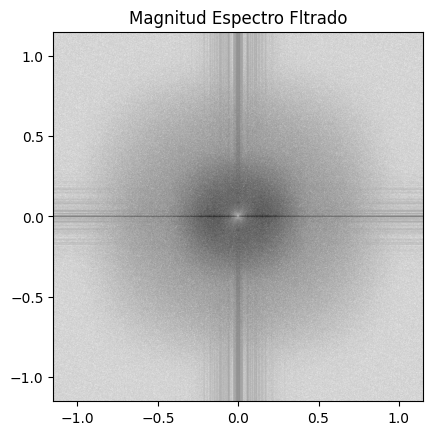

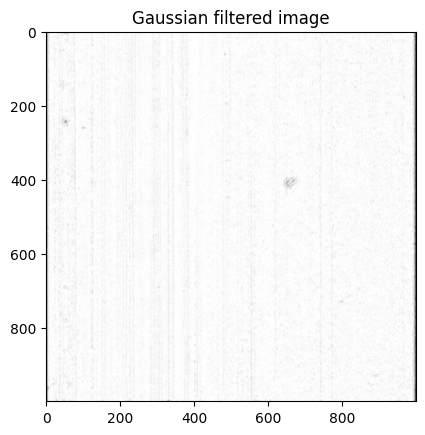

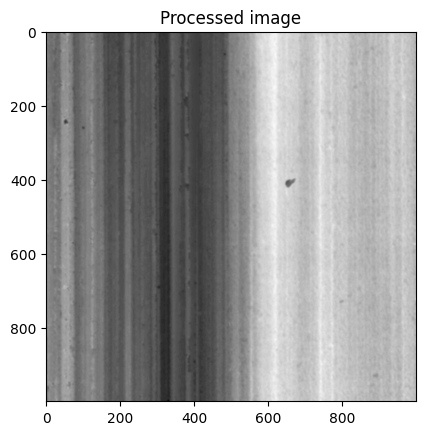

In [8]:
# Apply the filter to the shifted FFT.
fft_filtrada = fft_desplazada * kernel_gaussiano
magnitud_espectro_filtrado = np.log(np.abs(fft_filtrada) + 1)
plt.imshow(magnitud_espectro_filtrado, extent=[-ejef_x[-1], ejef_x[-1], -ejef_x[-1], ejef_x[-1]], cmap='gray_r')
plt.title('Magnitud Espectro Fltrado')
plt.show()

# Perform the inverse FFT.
imagen_filtrada = np.fft.ifft2(np.fft.ifftshift(fft_filtrada))
imagen_filtrada = np.abs(imagen_filtrada)

# Plot it
plt.imshow(imagen_filtrada, cmap='gray_r')
plt.title('Gaussian filtered image')
plt.show()

plt.imshow(img_processed, cmap='gray_r')
plt.title('Processed image')
plt.show()

We can see that the filtered image only have de short peaks and not the large ondulations

With all this preprocessing, we can now get all the roughnesses we need: Sa, Sz and Sa λ<10um. All the roughnesses are obtained from the processed part, corresponding to the 30% of the final part of the image, as can be seen in the image.

<img src="./data/FWHM.pbm">


In [ ]:
# "Sa" without inclination correction
processed_surface = img_processed[:,int(0.65*distancias.shape[1]):]
processed_surface = processed_surface - np.mean(processed_surface, axis=None)
Sa = np.mean(np.abs(processed_surface), axis=None)
print('Sa raw: ' + str(Sa) + ' µm')

# "Sa" and "Sz" with inclination correction
processed_surface = distancias[:,int(0.65*distancias.shape[1]):]

processed_surface = processed_surface - np.mean(processed_surface, axis=None)
Sa = np.mean(np.abs(processed_surface), axis=None)
print('Inclination-corrected Sa: ' + str(Sa) + ' µm')

Sz = np.abs(np.max(processed_surface) - np.min(processed_surface))
print('Inclination-corrected Sz: ' + str(Sz) + ' µm')

# "Inclination-corrected Sa" with filtering
filtered_surface = imagen_filtrada[:,int(0.65*imagen_filtrada.shape[1]):]
filtered_surface = filtered_surface - np.mean(filtered_surface, axis=None)

Sa_10um = np.mean(np.abs(filtered_surface), axis=None)
print('Sa λ<10: ' + str(Sa_10um) + ' µm')

Sa raw: 0.526115916812533 µm
Sa inclinación corregida: 0.4607966791835507 µm
Sz inclinación corregida: 4.432990335896153 µm
Sa lambda<10: 0.06732826778265394 µm


Another parameter that we need to calculate is the ‘Average step height’, which is defined as the difference between the averages of the data from the reference surface and the processed surface. Specifically, this value is obtained by first averaging the data from the reference surface and then averaging the data from the surface that has been processed or altered in some way. Finally, the ‘Average step height’ is calculated by taking the difference between these two averages.

In [ ]:
reference_surface = distancias[:, :int(0.35*distancias.shape[1])]
processed_surface = distancias[:,int(0.65*distancias.shape[1]):]
average_step_height = np.abs(np.mean(reference_surface) - np.mean(processed_surface))
print('Average step height: ' + str(average_step_height) + ' µm')

Average step height: 10.18548695875311 µm
